In [1]:
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import h5py
import cv2
import os
import sys




ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)
# Path to the processed and raw folders in the data
PROCESSED_PATH = os.path.join(ROOT_DIR, "../data/processed/")
RAW_PATH = os.path.join(ROOT_DIR, "../data/raw/")
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
import numpy as np
from preprocessing.utils import visualise_image, visualise_masks
from scipy.spatial import distance


In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8,16,3,padding=1)
        self.conv3 = nn.Conv2d(16,32,3,padding=1)
        
        self.deconv1 = nn.ConvTranspose2d(32,16,2,stride =2)
        self.conv4 = nn.Conv2d(32,16,3,padding=1)
    
        self.deconv2 = nn.ConvTranspose2d(16,8,2, stride = 2)
        self.conv5 = nn.Conv2d(16,8,3,padding=1)
        
        self.conv6 = nn.Conv2d(8,4,3,padding=1)
        
        self.conv7 = nn.Conv2d(4,1,1)

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = F.relu(x1)
        
       
        
        x2 = self.pool(x1)
        x2 = self.conv2(x2)
        x2 = F.relu(x2)
        

        x3 = self.pool(x2)
        x3 = self.conv3(x3)
        x3 = F.relu(x3)
        
        x4 = self.deconv1(x3)
        x4 = torch.cat((x4, x2), 1)
        x4 = self.conv4(x4)
        x4 = F.relu(x4)
        
        
        x5 = self.deconv2(x4)
        x5 = torch.cat((x5, x1), 1)
        x5 = self.conv5(x5)
        x5 = F.relu(x5)
        
        
        x6 = self.conv6(x5)
        x6 = F.relu(x6)
        x7 = self.conv7(x6)
    
        return x7


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv1): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2))
  (conv5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(4, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [3]:
class Data(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, file_path, transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.f = h5py.File(file_path, "r")
        self.transform = transform
        self.datapoints = self.f['datapoints'].value[0]

    def __len__(self):
        return self.datapoints

    def __getitem__(self, idx):
        frame = "datapoint{}".format(idx)
        image = self.f[frame]['masks'].value
        label = self.f[frame]['future_mask'].value
        
        sample = {'input': image.astype(np.float), 'label': label.astype(np.float), 'centroid':self.f[frame]['future_centroid'].value}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['input'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        
        image = cv2.resize(image, (int(256),int( 128)))
        label = cv2.resize(label, (int(256),int( 128)))
        
        image = image.transpose((2, 0, 1))
        return {'input': torch.from_numpy(image).float(),
                'label': torch.from_numpy(label).float(),
                'centroid': sample['centroid']}

In [5]:
data_file_name = "football1_sm5"
dataset_file = os.path.join(PROCESSED_PATH, "{}/{}_dataset.hdf5".format(data_file_name,data_file_name))
dataset = Data(dataset_file, transform = ToTensor())

In [6]:
dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True)

In [7]:
def find_mean_distance(batch_outputs, batch_c_true):
    #TODO: make sure that centroid coordinates start counting from 0 rather than from 1
    
    np_gauss = batch_gauss.detach().numpy()
    np_gauss = np.squeeze(np_gauss)
    np_c_true = batch_c_true.numpy()
    
    batch_c_pred = np.stack([np.unravel_index(np.argmax(np_gauss[i,:,:]),np_gauss[i,:,:].shape) for i in range(np_gauss.shape[0])],axis=0)
    dist = np.linalg.norm(batch_c_pred-np_c_true, axis = 1)
    
    return np.mean(dist)

In [8]:
criterion = nn.MSELoss(size_average = False) 
optimizer = optim.RMSprop(net.parameters(), lr=0.001)


for epoch in range(10):  # loop over the dataset multiple times

    running_loss = []
    running_distance = []
    for i, data in enumerate(dataloader):
        # get the inputs
        inputs = data['input']
        labels = data['label']
        labels = labels.unsqueeze(1)
        
        
        # zero the parameter gradients
        optimizer.zero_grad()
    
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        l2 = loss.item()
        c_true = data['centroid']
        
        dist = find_mean_distance(outputs,c_true)

        running_distance.append(dist)
        running_loss.append(loss.item())
    if epoch % 1 == 0:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f distance : %.3f' %
              (epoch + 1, i + 1, running_loss[i],running_distance[i]))




[1,    49] loss: 406.608 distance : 37.816
[2,    49] loss: 593.794 distance : 48.779
[3,    49] loss: 318.901 distance : 35.025
[4,    49] loss: 102.362 distance : 39.994
[5,    49] loss: 208.653 distance : 31.642
[6,    49] loss: 225.597 distance : 34.956
[7,    49] loss: 288.561 distance : 25.921
[8,    49] loss: 604.607 distance : 36.840
[9,    49] loss: 318.393 distance : 30.403
[10,    49] loss: 316.740 distance : 39.052


In [9]:
outputs = net(inputs)
outputs.shape

torch.Size([3, 1, 128, 256])

torch.Size([3, 1, 128, 256])
161.913
tensor(312.9189)
[[-0.06618077 -0.0618821  -0.06583966 ..., -0.06595846 -0.07346298
  -0.10118787]
 [-0.01261692 -0.00326644 -0.00522986 ..., -0.00261842 -0.02042756
  -0.0630604 ]
 [-0.00297286  0.0099875   0.01589788 ...,  0.0160635  -0.00408654
  -0.05188513]
 ..., 
 [-0.00596829  0.00550367  0.00578885 ...,  0.01131256 -0.00457163
  -0.05354764]
 [-0.01944096 -0.00792722 -0.00344522 ...,  0.00148526 -0.01442204
  -0.06034346]
 [-0.03520022 -0.03005922 -0.02671822 ..., -0.02391271 -0.03483761
  -0.07859935]]
221.729


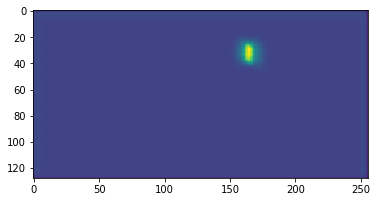

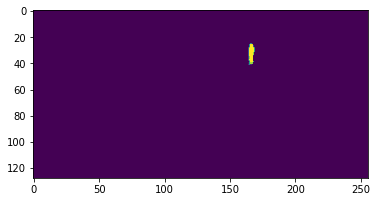

[ 0.          0.02856445  0.05053711  0.05151367  0.11791992  0.12133789
  0.15161133  0.18530273  0.25756836  0.26953125  0.40649414  0.41088867
  0.4375      0.46508789  0.49609375  0.59057617  0.59765625  0.66967773
  0.77954102  0.8125      0.82421875  0.8425293   0.86450195  0.94067383
  0.94506836  0.98266602  1.        ]
245.889


In [10]:
import matplotlib
import matplotlib.pyplot as plt

print(labels.shape)
loss = criterion(outputs, labels)

print(np.sum(np.square(outputs.detach().numpy()[2,0,:,:] - labels.detach().numpy()[2,0,:,:])))

print(loss)

print(outputs.detach().numpy()[2,0,:,:])

print(np.sum(outputs.detach().numpy()[2,0,:,:]))

visualise_image(outputs.detach().numpy()[1,0,:,:] )
visualise_image(labels.detach().numpy()[1,0,:,:])
print(np.unique(labels.detach().numpy()[1,0,:,:]))

print(np.sum(labels.detach().numpy()[2,0,:,:]))



In [11]:
def plot_metrics(metric):
    plt.plot(np.arange(len(metric)), metric)
    plt.show()
    

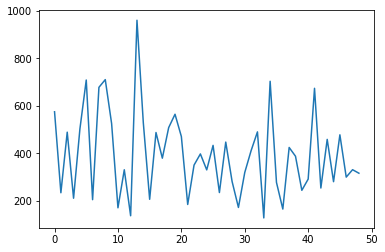

In [12]:
plot_metrics(running_loss)

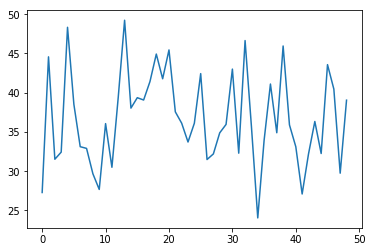

In [13]:
plot_metrics(running_distance)

In [14]:
for i in range(len(dataset)):
    print(i)
    sample = dataset[i]
    print(sample['input'].size(),sample['label'].size())

0
torch.Size([3, 128, 256]) torch.Size([128, 256])
1
torch.Size([3, 128, 256]) torch.Size([128, 256])
2
torch.Size([3, 128, 256]) torch.Size([128, 256])
3
torch.Size([3, 128, 256]) torch.Size([128, 256])
4
torch.Size([3, 128, 256]) torch.Size([128, 256])
5
torch.Size([3, 128, 256]) torch.Size([128, 256])
6
torch.Size([3, 128, 256]) torch.Size([128, 256])
7
torch.Size([3, 128, 256]) torch.Size([128, 256])
8
torch.Size([3, 128, 256]) torch.Size([128, 256])
9
torch.Size([3, 128, 256]) torch.Size([128, 256])
10
torch.Size([3, 128, 256]) torch.Size([128, 256])
11
torch.Size([3, 128, 256]) torch.Size([128, 256])
12
torch.Size([3, 128, 256]) torch.Size([128, 256])
13
torch.Size([3, 128, 256]) torch.Size([128, 256])
14
torch.Size([3, 128, 256]) torch.Size([128, 256])
15
torch.Size([3, 128, 256]) torch.Size([128, 256])
16
torch.Size([3, 128, 256]) torch.Size([128, 256])
17
torch.Size([3, 128, 256]) torch.Size([128, 256])
18
torch.Size([3, 128, 256]) torch.Size([128, 256])
19
torch.Size([3, 128,

torch.Size([3, 128, 256]) torch.Size([128, 256])
178
torch.Size([3, 128, 256]) torch.Size([128, 256])
179
torch.Size([3, 128, 256]) torch.Size([128, 256])
180
torch.Size([3, 128, 256]) torch.Size([128, 256])
181
torch.Size([3, 128, 256]) torch.Size([128, 256])
182
torch.Size([3, 128, 256]) torch.Size([128, 256])
183
torch.Size([3, 128, 256]) torch.Size([128, 256])
184
torch.Size([3, 128, 256]) torch.Size([128, 256])
185
torch.Size([3, 128, 256]) torch.Size([128, 256])
186
torch.Size([3, 128, 256]) torch.Size([128, 256])
187
torch.Size([3, 128, 256]) torch.Size([128, 256])
188
torch.Size([3, 128, 256]) torch.Size([128, 256])
189
torch.Size([3, 128, 256]) torch.Size([128, 256])
190
torch.Size([3, 128, 256]) torch.Size([128, 256])
191
torch.Size([3, 128, 256]) torch.Size([128, 256])
192
torch.Size([3, 128, 256]) torch.Size([128, 256])
193
torch.Size([3, 128, 256]) torch.Size([128, 256])
194
torch.Size([3, 128, 256]) torch.Size([128, 256])


In [15]:
for i, data in enumerate(dataloader):
        # get the inputs
        inputs = data['input']
        labels = data['label']
        labels = labels.unsqueeze(1)